<a href="https://colab.research.google.com/github/cswcjt/Deep_Learning/blob/main/cifar100_vanilla_ResNet50_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 ### Citizen Developer 과정.

> **Deep Learning Track. Mini PJT - CIFAR100 classification**


저희는 수업시간에 CIFAR10을 분류하는 문제를 풀어보았습니다.

이 때 까지 배운 모든 방법을 사용하여, CIFAR100 데이터셋을 100가지로 분류하는 문제를 풀어보세요.
프로젝트를 수행할 때, 다음 조건들을 만족하여야 합니다.

----

1.  MLP, (Vanilla)CNN, ResNet50 중에 2개의 모델을 골라서 구현합니다.


2. 각 모델을 design하여 (hyper-parameter를 세팅) 구현합니다.


3. Validation Accuracy 기준 0.4를 넘기는 모델과 학습 세팅을 찾습니다.

----

> 모델을 구현하고 성능을 올리기 위한 팁들을 몇 가지 소개합니다.

- learning rate가 optimization에 가장 큰 영향을 끼칩니다. 다양한 숫자를 테스트해보세요.


- 처음에 학습이 잘되는 세팅을 찾기 위해서는 10 epoch 정도로 초반 학습 성능이 잘나오는지 확인하는게 중요합니다. (val acc도 포함)


- 초반 학습 성능이 잘 나왔다면, epochs를 늘려서 학습이 잘되는지 확인합니다.


- epoch를 늘려도 한계에 도달했다면, overfitting이 되었는지 아닌지 확인합니다.


- overfitting이 되었다면, 여러 regularization 기법들이 도움이 될 겁니다. e.g. tensorflow.keras.layers.Dropout


- batch size도 바꿔보세요. batch size가 full-batch에 가까울 수록, 속도는 느려지지만 optimizer의 방향은 최적의 값을 향합니다.


- MLP나 CNN을 구현하고 있다면, 모델의 크기를 바꿔보세요. 파라미터가 많을 수록, 학습할 수 있는 정보가 많아집니다.

In [1]:
# Import Libraries
import numpy as np
import tensorflow as tf
import random
import os

# cifar100과 keras layer들 불러오기
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.layers import Dense, Input, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras import Sequential

In [2]:
## mini batch 데이터의 변경을 막기 위한 random seed 고정
def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(0xC0FFEE)

In [3]:
# Load Datasets
(X_train, y_train), (X_test, y_test) = cifar100.load_data()
print(X_train.shape) # 4차원 Tensor
print(X_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


### Preprocessing

1. Normalization (v)


2. Standardization

In [4]:
preprocessing = "standard" # "standard"
debug_mode = False

In [5]:
# Normalization (Minmax scaling)
if preprocessing == "normalize":
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.

In [6]:
# Standarization
if preprocessing == "standard":
    if debug_mode:
        print("-- Before --")
        print("Training data\n", X_train[0])

    img_mean = np.mean(X_train, axis=0)
    img_std = np.std(X_train, axis=0)

    if debug_mode:
        print(img_mean.shape)
        print(img_std.shape)

        print("mean : ", np.mean(X_train)) # through data
        print("std : ", np.std(X_train))

    # Scaling
    X_train = X_train.astype(np.float32) - img_mean
    X_train = X_train.astype(np.float32) / img_std

    if debug_mode:
        print("\n\n-- After --")
        #print("Training data\n", X_train[0])
        print("mean : ", np.mean(X_train))
        print("std : ", np.std(X_train))
    
    # Scaling
    X_test = X_test.astype(np.float32) - img_mean
    X_test = X_test.astype(np.float32) / img_std

In [7]:
X_train[0]

array([[[ 1.53251193,  1.51296775,  1.44629107],
        [ 1.55153995,  1.53377838,  1.46330664],
        [ 1.54591772,  1.53056499,  1.45879109],
        ...,
        [ 0.77055431,  0.86360549,  0.70122931],
        [ 0.99200195,  1.11709595,  0.83759357],
        [ 0.6147392 ,  0.72577384,  0.39293219]],

       [[ 1.55410443,  1.53796805,  1.46989723],
        [ 1.56471202,  1.55032771,  1.47822947],
        [ 1.56327365,  1.55217166,  1.47830967],
        ...,
        [ 0.4680204 ,  0.5008764 ,  0.19913396],
        [ 0.35755549,  0.39788889, -0.04194801],
        [ 0.16715592,  0.213365  , -0.24865682]],

       [[ 1.56348386,  1.55198186,  1.4862925 ],
        [ 1.57694682,  1.56863003,  1.49818036],
        [ 1.59390365,  1.58947671,  1.5161559 ],
        ...,
        [ 0.72568033,  0.82667946,  0.45002623],
        [ 0.42875599,  0.54280933, -0.03044805],
        [-0.15475149, -0.06264002, -0.56121994]],

       ...,

       [[ 0.26914654,  0.81025376, -0.47233305],
        [ 0

### Training with Vanilla CNN

**Model Architecture**

> Conv - Relu - Conv - Relu - FC - FC

In [8]:
# 위의 Vanilla CNN 구조를 직접 구현해봅니다.
# filters는 주로 늘려간다 --> flatten에 들어갈 정보를 많이 확보하기 위해서.

model = Sequential([
    Input(shape=(32, 32, 3)),
    Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu'),
    Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu'),
    MaxPool2D(pool_size=2),
    Conv2D(24, 3, 1, padding='same', activation='relu'),
    Conv2D(48, 3, 1, padding='same', activation='relu'),
    MaxPool2D(2),
    Flatten(),
    Dropout(0.2), # 오버피팅 막는 방법 중 하나
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(100, activation='softmax') # softmax
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 24)        3480      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 48)        10416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 48)         0         
 2D)                                                    

In [9]:
# training setup
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint

# val_loss 기준 체크포인터도 생성합니다.
cnn_filename = "CNN_best_model.ckpt"
checkpoint = ModelCheckpoint(cnn_filename, 
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


## config variables
batch_size = 258
lr = 1e-3
epochs = 30

# learning rate를 업데이트 해보려고 합니다: def scheduler --> epoch 기준으로 learning rate 바꾸는 함수를 정의
# ReduceLROnPlateau --> validation 기준으로 learning rate 바꾸는 방식
def scheduler(epoch, learning_rate):
    if epoch < 25:
        return learning_rate
    elif epoch < 50:
        return lr/10
    elif epoch < 75:
        return lr/50
    else:
        return lr/100    

# Set optimizer, loss function, metrics, callback function
#optimizer = SGD(learning_rate=lr, momentum=0.9) # Momentum optimizer 
optimizer = Adam(learning_rate=lr)
loss_fn = 'sparse_categorical_crossentropy' # multi-class classification
metrics = ['accuracy']
lr_callback = LearningRateScheduler(scheduler)

model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=metrics)

In [10]:
# model training
# 한번만 직접 해봅시다!

history = model.fit(x=X_train,
                    y=y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=[lr_callback, checkpoint],
                    validation_data=(X_test, y_test))

Epoch 1/30

Epoch 1: val_loss improved from inf to 3.16603, saving model to CNN_best_model.ckpt
194/194 - 12s - loss: 3.6831 - accuracy: 0.1524 - val_loss: 3.1660 - val_accuracy: 0.2430 - lr: 0.0010 - 12s/epoch - 64ms/step
Epoch 2/30

Epoch 2: val_loss improved from 3.16603 to 2.74581, saving model to CNN_best_model.ckpt
194/194 - 3s - loss: 2.9171 - accuracy: 0.2867 - val_loss: 2.7458 - val_accuracy: 0.3209 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 3/30

Epoch 3: val_loss improved from 2.74581 to 2.58909, saving model to CNN_best_model.ckpt
194/194 - 3s - loss: 2.5095 - accuracy: 0.3667 - val_loss: 2.5891 - val_accuracy: 0.3515 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 4/30

Epoch 4: val_loss improved from 2.58909 to 2.48285, saving model to CNN_best_model.ckpt
194/194 - 3s - loss: 2.2051 - accuracy: 0.4295 - val_loss: 2.4829 - val_accuracy: 0.3794 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 5/30

Epoch 5: val_loss improved from 2.48285 to 2.45790, saving model to CNN_best_model.ckpt
19

In [11]:
# evaluate
loss, acc = model.evaluate(X_test, y_test, batch_size=batch_size)
print("Loss : %.4f, Accuracy : %.4f" % (loss, acc))

39/39 [==============================] - 0s 7ms/step - loss: 4.3663 - accuracy: 0.3988
Loss : 4.3663, Accuracy : 0.3988


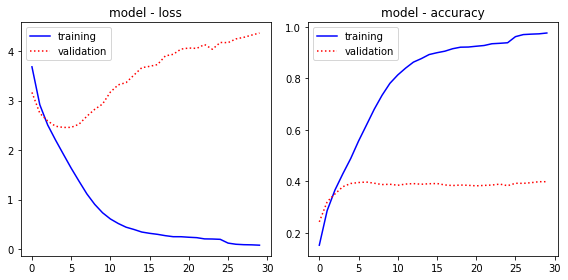

In [12]:
## loss visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1, 2,1)
plt.plot(history.history['loss'],'b-', label = "training")
plt.plot(history.history['val_loss'], 'r:', label = "validation")
plt.title("model - loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("model - accuracy")

plt.plot(history.history['accuracy'], 'b-', label = "training")
plt.plot(history.history['val_accuracy'], 'r:', label = "validation")

plt.legend()
plt.tight_layout()
plt.show()

### 이번엔 ResNet50를 사용해봅시다.

- ResNet50을 사용하기 위해서는 keras에 구현되어 있는 ResNet50 구조를 가져옵니다.

- pretrained를 가져오는 경우도 있지만, 지금은 ImageNet 세팅이 아니므로 구조만 가져옵니다.(input이 완전히 다름)

- Reference : https://keras.io/api/applications/resnet/#resnet50-function

In [13]:
# load ResNet50
from tensorflow.keras.applications import ResNet50

resnet = ResNet50(
    include_top=True,        # classification : True,  embedding : False
    weights=None,             # ImageNet pretrained : True, else : None
    input_shape=(32, 32, 3),  # if not pretrained, you must specify.
    pooling='max',
    classes=100,               # number of classes
    classifier_activation='softmax'    # output function
)

In [14]:
# see ResNet50 model
#resnet.summary()

In [15]:
### resnet training strategy
# val_loss 기준 체크포인터도 생성합니다.
resnet_filename = "resnet_best_model.ckpt"
checkpoint = ModelCheckpoint(resnet_filename, 
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)


## config variables
batch_size = 64
lr = 5e-3
epochs = 30

# learning rate를 업데이트 해보려고 합니다
def scheduler(epoch, learning_rate):
    if epoch < 5:
        return learning_rate
    elif epoch < 10:
        return lr/10
    elif epoch < 15:
        return lr/50
    else:
        return lr/100
    
#optimizer = SGD(learning_rate=lr, momentum=0.9)
optimizer = Adam(learning_rate=lr)
loss_fn = 'sparse_categorical_crossentropy'
metrics = ['accuracy']

resnet.compile(optimizer=optimizer,
               loss=loss_fn,
               metrics=metrics)

In [16]:
# training ResNet50
resnet_history = resnet.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_test, y_test),
                            callbacks=[lr_callback, checkpoint],
                            verbose=1)

Epoch 1/30
782/782 [==============================] - ETA: 0s - loss: 5.0467 - accuracy: 0.0252
Epoch 1: val_loss improved from inf to 4.50041, saving model to resnet_best_model.ckpt
782/782 [==============================] - 45s 50ms/step - loss: 5.0467 - accuracy: 0.0252 - val_loss: 4.5004 - val_accuracy: 0.0299 - lr: 0.0050
Epoch 2/30
781/782 [============================>.] - ETA: 0s - loss: 4.1039 - accuracy: 0.0560
Epoch 2: val_loss improved from 4.50041 to 4.23596, saving model to resnet_best_model.ckpt
782/782 [==============================] - 37s 48ms/step - loss: 4.1037 - accuracy: 0.0561 - val_loss: 4.2360 - val_accuracy: 0.0596 - lr: 0.0050
Epoch 3/30
781/782 [============================>.] - ETA: 0s - loss: 3.8511 - accuracy: 0.0939
Epoch 3: val_loss improved from 4.23596 to 3.75589, saving model to resnet_best_model.ckpt
782/782 [==============================] - 38s 49ms/step - loss: 3.8511 - accuracy: 0.0939 - val_loss: 3.7559 - val_accuracy: 0.1054 - lr: 0.0050
Epoch

In [17]:
# evaluate
loss, acc = resnet.evaluate(X_test, y_test, batch_size=batch_size)
print("Loss : %.4f, Accuracy : %.4f" % (loss, acc))

157/157 [==============================] - 2s 15ms/step - loss: 2.9713 - accuracy: 0.4454
Loss : 2.9713, Accuracy : 0.4454


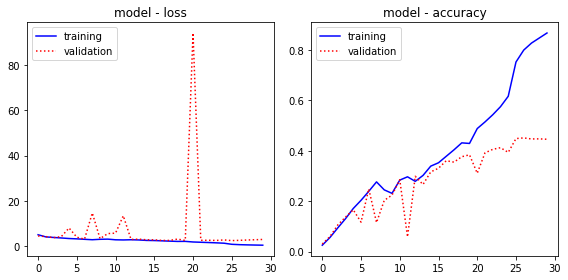

In [18]:
## loss visualize
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.subplot(1, 2,1)
plt.plot(resnet_history.history['loss'],'b-', label = "training")
plt.plot(resnet_history.history['val_loss'], 'r:', label = "validation")
plt.title("model - loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.title("model - accuracy")

plt.plot(resnet_history.history['accuracy'], 'b-', label = "training")
plt.plot(resnet_history.history['val_accuracy'], 'r:', label = "validation")

plt.legend()
plt.tight_layout()
plt.show()